Imports

In [85]:
!pip install sodapy
import pandas as pd
import numpy as np
import requests
import json
from sodapy import Socrata
import datetime
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


dataset api

In [86]:
domain = "data.cdc.gov"
dataset_identifier = "x9gk-5huc"
#open client
client = Socrata(domain, None)

Lists of modeled diseases in the correct format for api query

In [87]:
modeling_list = [
    "Tuberculosis",
    "Zika virus disease, non-congenital",
    # "Measles, Imported",
    "Measles, Indigenous",
    "Arboviral diseases, West Nile virus disease",
    "Novel Influenza A virus infections",
    "Hepatitis A, Confirmed",
    "Hepatitis B, acute"
]

Helper Functions: get x weeks ago and prep model

In [88]:
#returns:
#   xweeksago in iso format
#   this week in iso format
#   this year in iso format
#param
#   x is how many weeks ago to get data
def get_X_weeks_ago(x):
  today = datetime.date.today()
  x_weeks_ago = today - datetime.timedelta(weeks=x)
  return x_weeks_ago.isocalendar().week, datetime.date.today().isocalendar().week, datetime.date.today().year

In [89]:
#Purpose: run before every model to get all data needed
# Expected columns in df:
# states, year, week, label, m1, m2, m3, m4
#
# Returns:
#       df_state: state-only, disease-only dataframe
#       pop: state's population
#       current_week: latest available epidemiological week
#       new_cases: m1 value for current week
#requires:
# state_pop csv in files section
def prep_model(state, x, disease_name):
  #2024 population estimates from US Census data
  state_population_all = pd.read_csv("NST-EST2024-ALLDATA.csv")
  state_population = state_population_all[["STATE", "NAME", "POPESTIMATE2024"]]
  state_population = state_population[state_population["NAME"] == state]


  X_weeks_ago, this_week, this_year = get_X_weeks_ago(x)

  #retrieve info from api
  results = client.get(
    dataset_identifier,
    select="states, year, week, label, m1, m1_flag, m2, m3, m4",
    where=(
        f"year = '{this_year}' AND week >= '{X_weeks_ago}' "
        f"AND label = '{disease_name}' AND states = '{state}'"
    ),
    limit=10000
  ) #if contains m1_flag, no cases

  df = pd.DataFrame.from_records(results)

  # If no m1 column, no cases

  #if no cases, return null
  if df.empty or "m1" not in df.columns:
    print(f"[WARN] No Socrata data found for {disease_name} in {state} "+
          "for the specified period. Returning None for all.")
    return None, None, None, None

  df["week"] = pd.to_numeric(df["week"], errors = "coerce").fillna(0).astype(int)
  df["m1"] = pd.to_numeric(df["m1"], errors = "coerce").fillna(0).astype(int)

  #sort by time
  df = df.sort_values(["year","week"])

  #get latest available week / year
  curr_year = df["year"].max()
  curr_week = df[df["year"] == curr_year]["week"].max()
  #get latest cases
  # Extract most recent cases
  row = df[(df["year"] == curr_year) &
                   (df["week"] == curr_week)]
  if row.empty:
     print(f"[WARN] No m1 data for {state} {disease_name} at week {curr_week}")
     num_new_cases = 0
  else:
     # 'm1' is already an integer due to the conversion above
     num_new_cases = row["m1"].values[0]
  #sum all of m1 (for likely estimate of active cases for I0)
  active_cases = df["m1"].sum()

  return df, state_population["POPESTIMATE2024"], int(curr_week), int(num_new_cases)#, int(active_cases)



In [90]:

def get_vaccination_rates(vacc_name, state):
  #call cdc vaccine dataset estimates
  vacc_domain = "data.cdc.gov"
  vacc_identifier = "ijqb-a7ye"
  client_vacc = Socrata(vacc_domain, None)
  #get MMR vaccine estimate info by state/school year
  results_vacc = client_vacc.get(
    vacc_identifier,
    select="vaccine, geography_type, geography, year_season, coverage_estimate",
    where =( f"vaccine = '{vacc_name}' AND geography = '{state}'"),
    limit=10
  )
  results_vacc = pd.DataFrame.from_records(results_vacc)
  results_vacc["year_season"] = results_vacc["year_season"].astype(str)
  results_vacc["coverage_estimate"] = pd.to_numeric(results_vacc["coverage_estimate"], errors='coerce')
  #sort and return most recent statistic
  results_vacc = results_vacc.sort_values(by="year_season", ascending=False)
  results_vacc = results_vacc.reset_index(drop=True)

  return results_vacc["year_season"][0], results_vacc["coverage_estimate"][0]



#Tuberculosis

In [91]:
##BASED ON PAPER
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- helper: convert per-year to per-week
def yr_to_week(rate_per_year):
    return rate_per_year / 52.0

# --- paper baseline parameters (Table 2) converted to per-week units
PAPER_BASELINE = {
    # demographic
    "mu": yr_to_week(0.02041),         # natural death per week
    "Lambda": 3768410.0 / 52.0,       # recruitment per week (paper gives per-year)
    # transmission & modification
    "beta": 10.0 / 52.0,               # placeholder (paper lists β variable, baseline range [6.55,15]/yr)
    "eta1": 0.7,                       # dimensionless (0..1)
    "eta2": 0.9,
    # progression / detection / diagnosis (per year -> per week)
    "k": yr_to_week(0.0005),
    "alpha": yr_to_week(1.1),
    "p": 0.1,                          # fraction (dimensionless)
    "b1": 0.7,
    "b2": 0.8,
    "b3": 1.2,
    "n": 0.2,
    "sigma": yr_to_week(1.1),          # diagnosis of latent per week
    "q": 0.4,
    "kappa": yr_to_week(1.2),          # detection of active per week
    # disease-induced death (per year -> per week)
    "delta1": yr_to_week(0.413),
    "delta2": yr_to_week(0.139),
    "delta3": yr_to_week(0.300),
    # treatment rates (per year -> per week)
    "r0": yr_to_week(1.5),
    "r1": yr_to_week(2.5),
    "r2": yr_to_week(1.5),
}

def model_treatment_paper(state,
                          weeks=104,
                          weeks_back=20,
                          params=None,
                          init=None,
                          obs_model="prevalence",
                          reporting_rate=1.0,
                          plot=True,
                          y_log = False,
                          verbose=False):
    """
    Implements the 8-compartment TB treatment model from Egonmwan & Okuonghae (2018).
    - state: string passed to your prep_model(state, weeks_back, "Tuberculosis")
    - weeks: forecast horizon in weeks
    - weeks_back: how many historical weeks to load for initialization/overlay
    - params: dict overriding PAPER_BASELINE keys
    - init: dict with initial compartment values {'S','E1','E2','E3','I','J1','J2','T'} optionally
    - obs_model: "prevalence" (I) or "incidence" (sigma * E1? in paper incidence is flux into I)
    - reporting_rate: multiplier for observed output (if fit provides different rate, pass it)
    Returns DataFrame with t_week and compartments and obs_pred_prevalence/incidence
    """
    # load historical data & population via your prep_model (keeps your pipeline)
    df_state, pop_series, _, m1_cases = prep_model(state, weeks_back, "Tuberculosis")
    if pop_series is None or df_state is None:
        raise ValueError("prep_model failed to return historical data or population")
    pop = pop_series.item()

    # merge params
    p = PAPER_BASELINE.copy()
    if params:
        p.update(params)

    # default initial conditions if not provided (paper suggests using Lambda/mu for N)
    N_star = p["Lambda"] / p["mu"] if p["mu"] > 0 else pop
    if init is None:
        # -------------------------------
        # PAPER-CONSISTENT LATENT INITIALIZATION
        # -------------------------------
        # Total latent fraction (default <<<.5% of population)
        latent_fraction = 0.000005
        latent_total = max(latent_fraction * pop_series.item(), 1.0)

        # Fractional split of the latent pool:
        # E1 = newly infected latent (small)
        # E2 = diagnosed latent (screened)
        # E3 = long-term latent (majority)
        E1_frac = 0.02   # 2% of latent are newly infected
        E2_frac = 0.10   # 10% diagnosed latent
        E3_frac = 1.0 - E1_frac - E2_frac

        # latent compartments
        E1_0 = latent_total * E1_frac
        E2_0 = latent_total * E2_frac
        E3_0 = latent_total * E3_frac

        # Active infectious from observed m1 or at least 1
        I0 = max(float(m1_cases) if m1_cases is not None else 0.0, 0.0)

        # Diagnosed infectious and treated compartments start at 0 unless data say otherwise
        J1_0 = 0.0
        J2_0 = 0.0
        T0  = 0.0

        # Susceptibles = population minus all other compartments
        S0 = max(pop - (E1_0 + E2_0 + E3_0 + I0 + J1_0 + J2_0 + T0), 0.0)

    else:
        S0 = init.get("S", max(pop - sum(init.get(k,0.0) for k in ["E1","E2","E3","I","J1","J2","T"]),0.0))
        # Changed L0 to E1_0
        E1_0 = init.get("E1", init.get("L",  max(0.000000001 * pop, 1.0)))
        E2_0 = init.get("E2", 0.0)
        # Changed L0 to E1_0
        E3_0 = init.get("E3", max(0.0, E1_0 * (1.0 - p["n"])))
        I0 = init.get("I", max(1.0, float(m1_cases) if m1_cases is not None else 1.0))
        J1_0 = init.get("J1", 0.0)
        J2_0 = init.get("J2", 0.0)
        T0 = init.get("T", 0.0)

    # Changed L0 to E1_0
    y0 = [S0, E1_0, E2_0, E3_0, I0, J1_0, J2_0, T0]

    # force of infection lambda
    def force_of_infection(I, J1, J2, N):
        return p["beta"] * (I + p["eta1"] * J1 + p["eta2"] * J2) / max(N, 1.0)

    # ODE system (paper Eq. 2.1)
    def deriv(t, y):
        S, E1, E2, E3, I, J1, J2, T = y
        N = max(S + E1 + E2 + E3 + I + J1 + J2 + T, 1.0)
        lam = force_of_infection(I, J1, J2, N)

        dS = p["Lambda"] - lam * S - p["mu"] * S

        dE1 = (1.0 - p["p"]) * lam * (S + p["b3"] * T) - (p["sigma"] + p["mu"]) * E1

        dE2 = p["sigma"] * p["n"] * E1 + p["alpha"] * E3 - p["b1"] * lam * E2 - (p["r0"] + p["mu"]) * E2

        dE3 = p["sigma"] * (1.0 - p["n"]) * E1 - p["b2"] * lam * E3 - (p["alpha"] + p["k"] + p["mu"]) * E3

        dI = p["p"] * lam * (S + p["b3"] * T) + p["b1"] * lam * E2 + p["b2"] * lam * E3 + p["k"] * E3 - (p["kappa"] + p["delta1"] + p["mu"]) * I

        dJ1 = p["kappa"] * p["q"] * I - (p["r1"] + p["delta2"] + p["mu"]) * J1

        dJ2 = p["kappa"] * (1.0 - p["q"]) * I - (p["r2"] + p["delta3"] + p["mu"]) * J2

        dT = p["r0"] * E2 + p["r1"] * J1 + p["r2"] * J2 - p["b3"] * lam * T - p["mu"] * T

        return [dS, dE1, dE2, dE3, dI, dJ1, dJ2, dT]

    t_eval = np.arange(0, weeks + 1)
    sol = solve_ivp(deriv, (0, weeks), y0, t_eval=t_eval, rtol=1e-6, atol=1e-8)
    S, E1, E2, E3, I, J1, J2, T = sol.y
    results = pd.DataFrame({
        "t_week": t_eval,
        "S": S, "E1": E1, "E2": E2, "E3": E3,
        "I": I, "J1": J1, "J2": J2, "T": T
    })
    results["N"] = results[["S","E1","E2","E3","I","J1","J2","T"]].sum(axis=1)

    # predicted observables (prevalence = I, incidence = flow into I)
    results["obs_pred_prevalence"] = results["I"] * reporting_rate
    # incidence: new active cases per week = p*k? In paper incidence to active = k*E3 + p*lam*(S+b3*T) + b1*lam*E2 + b2*lam*E3
    # but for reporting it is common to use sigma*nE1? We'll use new-actives flow:
    lam_series = [force_of_infection(I[i], J1[i], J2[i], results.loc[i,"N"]) for i in range(len(results))]
    results["incidence_to_I"] = p["p"] * np.array(lam_series) * (results["S"] + p["b3"] * results["T"]) + \
                                p["b1"] * np.array(lam_series) * results["E2"] + \
                                p["b2"] * np.array(lam_series) * results["E3"] + \
                                p["k"] * results["E3"]
    results["obs_pred_incidence"] = results["incidence_to_I"] * reporting_rate

    results["pred_m1"] = results["obs_pred_prevalence"] if obs_model == "prevalence" else results["obs_pred_incidence"]

    # optional plotting (overlay historical m1)
    if plot:
        try:
            hist_df, _, _, _ = prep_model(state, weeks_back, "Tuberculosis")
            hist_vals = hist_df["m1"].values
            t_hist = np.arange(len(hist_vals))

            plt.figure(figsize=(10,4))
            plt.plot(results["t_week"], results["pred_m1"], label="Model predicted m1")
            plt.plot(t_hist, hist_vals, "o-", label="Observed m1 (hist)")
            plt.plot(results["t_week"], results["E1"], label="New latent E1")
            plt.plot(results["t_week"], results["I"], label="Undiagnosed active I")

            plt.xlabel("Weeks")
            plt.ylabel("Counts")
            if y_log:
              plt.plot(results["t_week"], results["T"], label="Treated T")
              plt.yscale("log")
            plt.title(f"{state} TB model (paper treatment model) obs_model={obs_model}")
            plt.legend()
            plt.tight_layout()
            plt.show()
        except Exception as e:
            if verbose:
                print("Plot overlay failed:", e)

    return results, p

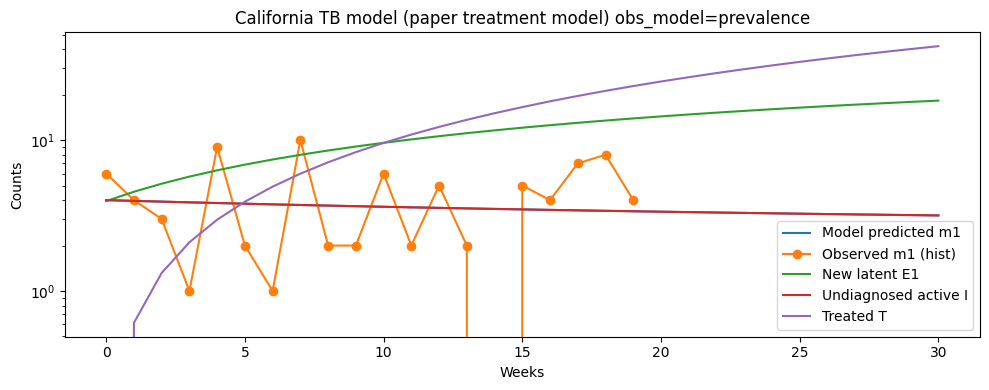

In [92]:
results, p = model_treatment_paper("California", weeks = 30, y_log=True)

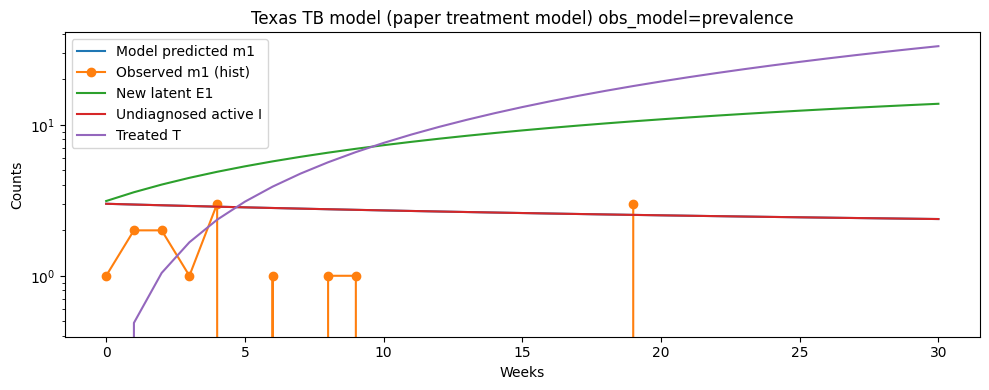

In [93]:
results, p = model_treatment_paper("Texas", weeks = 30, y_log=True)

#Zika

In [94]:
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt


# =============================================================
# 1. ZIKA PARAMETER FITTING
# =============================================================
def fit_zika_parameters(state, weeks_back=20, obs_model="incidence"):
    """
    Fit Zika transmission parameters to historical m1 case counts.
    """

    # Load historical data
    df_state, pop, _, _ = prep_model(state, weeks_back, "Zika virus disease, non-congenital")
    if df_state.empty or pop is None:
        return None
    y_obs = df_state["m1"].values.astype(float)
    N_h = int(pop)

    # Initial conditions
    I0 = max(y_obs[0], 0)
    E0 = 2 * I0
    R0 = 0
    S0 = max(N_h - I0 - E0, 0)

    # Vector population ratio (tunable)
    Nv = 3 * N_h
    Iv0 = 50
    Ev0 = 50
    Sv0 = Nv - Iv0 - Ev0

    y0 = [S0, E0, I0, R0, Sv0, Ev0, Iv0]
    t_eval = np.arange(len(y_obs))

    # Simulation for parameters p = [β_hv, β_vh, sigma_h, gamma_h]
    def simulate(p):
        beta_hv, beta_vh, sigma_h, gamma_h = p

        mu_v = 1/10       # mosquito lifespan ~10 days
        sigma_v = 1/7     # mosquito incubation ~7 days

        def deriv(t, y):
            S_h, E_h, I_h, R_h, S_v, E_v, I_v = y

            lambda_h = beta_vh * I_v / N_h
            lambda_v = beta_hv * I_h / N_h

            dS_h = -lambda_h * S_h
            dE_h =  lambda_h * S_h - sigma_h * E_h
            dI_h =  sigma_h * E_h - gamma_h * I_h
            dR_h =  gamma_h * I_h

            dS_v = mu_v*(S_v+E_v+I_v) - lambda_v * S_v - mu_v*S_v
            dE_v = lambda_v*S_v - sigma_v*E_v - mu_v*E_v
            dI_v = sigma_v*E_v - mu_v*I_v

            return [dS_h, dE_h, dI_h, dR_h, dS_v, dE_v, dI_v]

        sol = solve_ivp(
            deriv, (0, len(y_obs)-1), y0,
            t_eval=t_eval, rtol=1e-6, atol=1e-8
        )

        _, E_h, I_h, _, _, _, _ = sol.y

        if obs_model == "prevalence":
            return I_h
        else:
            return sigma_h * E_h   # incidence: new infections

    # Least squares fit
    def residuals(p):
        return simulate(p) - y_obs

    p0 = [0.3, 0.3, 1/5, 1/7]   # initial guesses
    bounds = ([0, 0, 0, 0], [5, 5, 1, 1])

    result = least_squares(residuals, p0, bounds=bounds)

    return {
        "beta_hv": result.x[0],
        "beta_vh": result.x[1],
        "sigma_h": result.x[2],
        "gamma_h": result.x[3]
    }



# =============================================================
# 2. FULL ZIKA SEIR/SEI VECTOR-BORNE MODEL
# =============================================================
def model_zika(state, weeks=104, weeks_back=20, verbose=False,
               beta_hv=None, beta_vh=None,
               sigma_h=None, gamma_h=None,
               obs_model="incidence",
               reporting_rate=1.0,
               plot=True):

    # Load for initial conditions
    df_state, pop, _, m1_cases = prep_model(state, weeks_back, "Zika virus disease, non-congenital")
    N_h = int(pop)

    # --- INITIAL CONDITIONS (FIXED) ---
    if m1_cases == 0:
        I0 = 0
        E0 = 0
    else:
        I0 = m1_cases
        E0 = 3 * I0

    R0 = 0
    S0 = max(N_h - E0 - I0, 0)

    # Vector initial conditions (FIXED)
    Nv = 3 * N_h
    if m1_cases == 0:
        Iv0 = 0
        Ev0 = 0
    else:
        Iv0 = 3
        Ev0 = 1

    Sv0 = Nv - Iv0 - Ev0

    y0 = [S0, E0, I0, R0, Sv0, Ev0, Iv0]

    # Parameter defaults (if not fitted)
    if sigma_h is None: sigma_h = 1/5
    if gamma_h is None: gamma_h = 1/7
    if beta_hv is None: beta_hv = 0.3
    if beta_vh is None: beta_vh = 0.3

    mu_v = 1/10
    sigma_v = 1/7

    if verbose:
        print("Parameters:", beta_hv, beta_vh, sigma_h, gamma_h)
        print("Initial conditions:", y0)

    def deriv(t, y):
        S_h, E_h, I_h, R_h, S_v, E_v, I_v = y

        lambda_h = beta_vh * I_v / N_h
        lambda_v = beta_hv * I_h / N_h

        dS_h = -lambda_h * S_h
        dE_h =  lambda_h * S_h - sigma_h * E_h
        dI_h =  sigma_h * E_h - gamma_h * I_h
        dR_h =  gamma_h * I_h

        dS_v = mu_v*(S_v+E_v+I_v) - lambda_v*S_v - mu_v*S_v
        dE_v = lambda_v*S_v - sigma_v*E_v - mu_v*E_v
        dI_v = sigma_v*E_v - mu_v*I_v

        return [dS_h, dE_h, dI_h, dR_h, dS_v, dE_v, dI_v]

    t_eval = np.arange(weeks+1)
    sol = solve_ivp(
        deriv, (0, weeks), y0,
        t_eval=t_eval, rtol=1e-6, atol=1e-8
    )

    S_h, E_h, I_h, R_h, S_v, E_v, I_v = sol.y

    results = pd.DataFrame({
        "t_week": t_eval,
        "S_h": S_h, "E_h": E_h, "I_h": I_h, "R_h": R_h,
        "S_v": S_v, "E_v": E_v, "I_v": I_v
    })

    # Observation model
    results["pred_prevalence"] = I_h * reporting_rate
    results["pred_incidence"]  = sigma_h * E_h * reporting_rate

    results["pred_m1"] = (
        results["pred_prevalence"]
        if obs_model == "prevalence"
        else results["pred_incidence"]
    )

    # Plot with historical overlay
    if plot:
        try:
            df_hist, _, _, _ = prep_model(state, weeks_back, "Zika virus disease, non-congenital")
            hist_vals = df_hist["m1"].values
            t_hist = np.arange(len(hist_vals))

            plt.figure(figsize=(9,4))
            plt.plot(results["t_week"], results["pred_m1"], label="Model predicted m1")
            plt.plot(t_hist, hist_vals, "o-", label="Observed m1")
            plt.plot(results["t_week"], results["E_h"], label = "Exposed (E_h)")
            plt.plot(results["t_week"], results["I_h"], label = "Infected (I_h)")
            plt.plot(results["t_week"], results["R_h"], label = "Recovered (R_h)")
            plt.legend()
            plt.xlabel("Weeks")
            plt.ylabel("Zika Cases")
            plt.title(f"{state} Zika Model ({obs_model}) - SEIR Compartments ")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            if verbose:
                print("Plot overlay failed:", e)

    return results



# =============================================================
# 3. ONE-CALL PIPELINE (fit + run + plot)
# =============================================================
def run_zika_pipeline(state,
                      weeks_back=20,
                      forecast_weeks=104,
                      obs_model="incidence",
                      reporting_rate=1.0,
                      verbose=True):

    if verbose:
        print(f"\n=== Fitting Zika parameters for {state} ===")

    params = fit_zika_parameters(
        state,
        weeks_back=weeks_back,
        obs_model=obs_model
    )

    #if no state data, returns None
    if params is None:
      print(f"No recent data found for: {state} within the last {weeks_back} weeks")
      return None, None

    if verbose:
        print("Fitted parameters:", params)

    results = model_zika(
        state,
        weeks=forecast_weeks,
        weeks_back=weeks_back,
        beta_hv=params["beta_hv"],
        beta_vh=params["beta_vh"],
        sigma_h=params["sigma_h"],
        gamma_h=params["gamma_h"],
        obs_model=obs_model,
        reporting_rate=reporting_rate,
        verbose=verbose,
        plot=True
    )

    return results, params


In [95]:
def fit_zika_parameters(state, weeks_back=20, obs_model="incidence"):
    """
    Fit Zika transmission parameters to historical m1 case counts with realistic bounds.
    """
    df_state, pop, _, _ = prep_model(state, weeks_back, "Zika virus disease, non-congenital")
    if df_state is None or pop is None:
        return None
    y_obs = df_state["m1"].values.astype(float)
    N_h = int(pop)

    # Initial human conditions
    I0 = max(y_obs[0], 1)  # at least 1
    E0 = 2 * I0
    R0 = 0
    S0 = max(N_h - I0 - E0, 0)

    # Vector population
    Nv = 1.5 * N_h  # realistic scaling
    Iv0 = 5
    Ev0 = 5
    Sv0 = Nv - Iv0 - Ev0

    y0 = [S0, E0, I0, R0, Sv0, Ev0, Iv0]
    t_eval = np.arange(len(y_obs))

    def simulate(p):
        beta_hv, beta_vh, sigma_h, gamma_h = p
        mu_v = 1/10
        sigma_v = 1/7

        def deriv(t, y):
            S_h, E_h, I_h, R_h, S_v, E_v, I_v = y
            lambda_h = beta_vh * I_v / N_h
            lambda_v = beta_hv * I_h / N_h

            dS_h = -lambda_h * S_h
            dE_h = lambda_h * S_h - sigma_h * E_h
            dI_h = sigma_h * E_h - gamma_h * I_h
            dR_h = gamma_h * I_h

            dS_v = mu_v*(S_v + E_v + I_v) - lambda_v*S_v - mu_v*S_v
            dE_v = lambda_v*S_v - sigma_v*E_v - mu_v*E_v
            dI_v = sigma_v*E_v - mu_v*I_v
            return [dS_h, dE_h, dI_h, dR_h, dS_v, dE_v, dI_v]

        sol = solve_ivp(deriv, (0, len(y_obs)-1), y0, t_eval=t_eval, rtol=1e-6, atol=1e-8)
        _, E_h, I_h, _, _, _, _ = sol.y
        return I_h if obs_model == "prevalence" else sigma_h * E_h

    def residuals(p):
        return simulate(p) - y_obs

    # realistic bounds to avoid pathological fits
    bounds = ([0.01, 0.01, 1/14, 1/14], [1.0, 1.0, 1/3, 1/3])
    p0 = [0.2, 0.2, 1/7, 1/7]

    result = least_squares(residuals, p0, bounds=bounds)
    return {"beta_hv": result.x[0], "beta_vh": result.x[1],
            "sigma_h": result.x[2], "gamma_h": result.x[3]}


def model_zika(state, weeks=104, weeks_back=20,
               beta_hv=None, beta_vh=None,
               sigma_h=None, gamma_h=None,
               obs_model="incidence",
               reporting_rate=1.0,
               plot=True, verbose=False):

    df_state, pop, _, m1_cases = prep_model(state, weeks_back, "Zika virus disease, non-congenital")
    N_h = int(pop)

    # Consistent initial human conditions
    I0 = max(m1_cases, 1)
    E0 = 2 * I0
    R0 = 0
    S0 = max(N_h - I0 - E0, 0)

    # Vector initial conditions
    Nv = 1.5 * N_h
    Iv0 = 5
    Ev0 = 5
    Sv0 = Nv - Iv0 - Ev0

    y0 = [S0, E0, I0, R0, Sv0, Ev0, Iv0]

    # Defaults if not fitted
    if sigma_h is None: sigma_h = 1/7
    if gamma_h is None: gamma_h = 1/7
    if beta_hv is None: beta_hv = 0.2
    if beta_vh is None: beta_vh = 0.2

    mu_v = 1/10
    sigma_v = 1/7

    def deriv(t, y):
        S_h, E_h, I_h, R_h, S_v, E_v, I_v = y
        lambda_h = beta_vh * I_v / N_h
        lambda_v = beta_hv * I_h / N_h

        dS_h = -lambda_h * S_h
        dE_h = lambda_h * S_h - sigma_h * E_h
        dI_h = sigma_h * E_h - gamma_h * I_h
        dR_h = gamma_h * I_h

        dS_v = mu_v*(S_v + E_v + I_v) - lambda_v*S_v - mu_v*S_v
        dE_v = lambda_v*S_v - sigma_v*E_v - mu_v*E_v
        dI_v = sigma_v*E_v - mu_v*I_v
        return [dS_h, dE_h, dI_h, dR_h, dS_v, dE_v, dI_v]

    t_eval = np.arange(weeks+1)
    sol = solve_ivp(deriv, (0, weeks), y0, t_eval=t_eval, rtol=1e-6, atol=1e-8)
    S_h, E_h, I_h, R_h, S_v, E_v, I_v = sol.y

    results = pd.DataFrame({
        "t_week": t_eval,
        "S_h": S_h, "E_h": E_h, "I_h": I_h, "R_h": R_h,
        "S_v": S_v, "E_v": E_v, "I_v": I_v
    })

    # Observation model
    results["pred_prevalence"] = I_h * reporting_rate
    results["pred_incidence"] = sigma_h * E_h * reporting_rate
    results["pred_m1"] = results["pred_prevalence"] if obs_model == "prevalence" else results["pred_incidence"]

    # Plot
    if plot:
        plt.figure(figsize=(9,4))
        plt.plot(results["t_week"], results["pred_m1"], label="Model predicted m1")
        hist_vals = df_state["m1"].values
        t_hist = np.arange(len(hist_vals))
        plt.plot(t_hist, hist_vals, "o-", label="Observed m1")
        plt.plot(results["t_week"], results["E_h"], label="Exposed (E_h)")
        plt.plot(results["t_week"], results["I_h"], label="Infected (I_h)")
        plt.plot(results["t_week"], results["R_h"], label="Recovered (R_h)")
        plt.legend()
        plt.xlabel("Weeks")
        plt.ylabel("Zika Cases")
        plt.title(f"{state} Zika Model ({obs_model})")
        plt.tight_layout()
        plt.show()

    return results



=== Fitting Zika parameters for Maryland ===


C:\Users\bobth\AppData\Local\Temp\ipykernel_9432\342476621.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  N_h = int(pop)


Fitted parameters: {'beta_hv': np.float64(0.7773276031530861), 'beta_vh': np.float64(0.010000000000000002), 'sigma_h': np.float64(0.07142857142857144), 'gamma_h': np.float64(0.07142857142878804)}


C:\Users\bobth\AppData\Local\Temp\ipykernel_9432\342476621.py:70: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  N_h = int(pop)


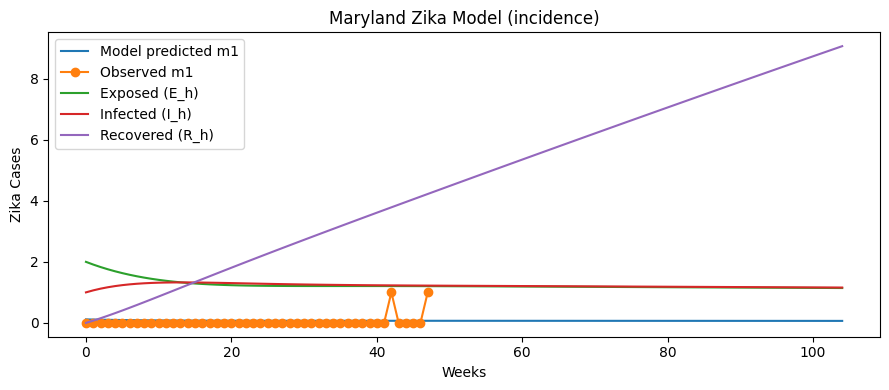

In [96]:
#The only zika case in the last year was in Maryland
results, params = run_zika_pipeline(
    "Maryland",
    weeks_back=100,
    forecast_weeks=104,
    obs_model="incidence",
    reporting_rate=0.8
)


#Measles

In [97]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt


"""
PURPOSE: fit mealses parameters by state and case info
"""
def fit_measles_parameters(state, weeks_back=20, obs_model="prevalence"):
  #get historical data
  df_state, pop_series, _, _ = prep_model(state, weeks_back, "Measles, Indigenous")
  # Handle cases where prep_model returns None (no data or other issue)
  if df_state is None or pop_series is None:
      print(f"[WARN] No Socrata data found for Measles, Indigenous in {state} for the specified period. Cannot fit model.")
      return None

  y_obs = df_state["m1"].values.astype(float)

  # Extract scalar population value from Series
  pop = pop_series.item()

  #get vaccination data
  vacc_year, vacc_rate = get_vaccination_rates("MMR",state)

  # Handle cases where vaccination data is None
  if vacc_rate is None:
      print(f"[WARN] No valid MMR vaccination data found for {state}. Cannot fit measles model.")
      return None

  #Initial Conditions
  V = int(pop * vacc_rate)
  I0 = max(y_obs[0], 5)
  E0 = 2 * I0
  R0 = 0
  S0 = max(pop - I0 - E0 - V, 0)
  print(f"S = {S0}, E = {E0}, I = {I0}, R = {R0}, V = {V}")

  y0 = [S0, E0, I0, R0, V]
  t_eval = np.arange(len(y_obs))

  # ODE system
  def simulate(params):
        beta, sigma, gamma = params
        omega = 0.0 #waning immunity
        def deriv(t, y):
            S, E, I, R, V = y
            N = S + E + I + R + V

            infection_force = beta*S*I/N

            dS = -infection_force - omega*V
            dE = infection_force - sigma*E
            dI = sigma*E - gamma*I
            dR = gamma*I
            dV = -omega*V
            return [dS, dE, dI, dR, dV]

        sol = solve_ivp(
            deriv, (0, len(y_obs)-1), y0,
            t_eval=t_eval, rtol=1e-6, atol=1e-8
        )
        S, E, I, R, V = sol.y

        if obs_model == "prevalence":
            return I
        else:
            return sigma * E

  # Residuals for least squares fitting
  def residuals(params):
        return simulate(params) - y_obs

  # Initial guesses
  p0 = [
      0.05,          # beta
      1/(52*3),      # sigma
      1/52           # gamma
  ]

  # Fit
  result = least_squares(
      residuals,
      p0,
      bounds=([0, 0, 0], [1, 1, 1])
  )

  beta_fit, sigma_fit, gamma_fit = result.x

  return {
      "beta": beta_fit,
      "sigma": sigma_fit,
      "gamma": gamma_fit,
      "R0_est": beta_fit / gamma_fit
  }

In [98]:
def model_measles(state, weeks=104, verbose=False,
                       beta=None, sigma=None, gamma=None,
                       mu=0.0, latent_multiplier=2, min_I0=1,
                       obs_model="prevalence", reporting_rate=1.0,
                       plot=True):
  df_state, pop_series, _, m1_cases = prep_model(state, 30, "Measles, Indigenous")

  # Handle cases where prep_model returns None
  if df_state is None or pop_series is None:
      print(f"[WARN] No Socrata data found for Measles, Indigenous in {state} for the specified period. Cannot run model.")
      return None # Or handle as appropriate for your application

  # Extract scalar population value from Series
  pop = pop_series.item()

  #TODO: handle when returns none
  df_state = df_state.sort_values(by="m1", ascending=False)

  I0 = max(m1_cases, min_I0)
  E0 = latent_multiplier * I0
  R0 = 0
  S0 = max(pop - I0 - E0, 0)
  V0 = int(pop * get_vaccination_rates("MMR",state)[1])

  #if no defaults provided
  if sigma is None: sigma = 1/(52*3)
  if gamma is None: gamma = 1/52
  if beta is None: beta = 1.3* gamma
  if verbose:
        print("Parameters used:")
        print(f"beta = {beta}, sigma = {sigma}, gamma = {gamma}")

    # ODE
  def deriv(t, y):
    S, E, I, R = y
    N = S + E + I + R
    dS = -beta * S * I / N + mu * (N - S)
    dE =  beta * S * I / N - sigma * E
    dI =  sigma * E - gamma * I
    dR =  gamma * I - mu * R
    return [dS, dE, dI, dR]

  t_eval = np.arange(0, weeks + 1)
  y0 = [S0, E0, I0, R0]

  sol = solve_ivp(
        deriv, (0, weeks), y0,
        t_eval=t_eval, rtol=1e-6, atol=1e-8
  )

  S, E, I, R = sol.y

  # Build results DataFrame
  results = pd.DataFrame({
        "t_week": t_eval,
        "S": S, "E": E, "I": I, "R": R,
        "N": S + E + I + R
  })

    # Observation model
  results["obs_pred_prevalence"] = results["I"] * reporting_rate
  results["obs_pred_incidence"] = sigma * results["E"] * reporting_rate

  if obs_model == "prevalence":
      results["pred_m1"] = results["obs_pred_prevalence"]
  else:
      results["pred_m1"] = results["obs_pred_incidence"]

    # Plot with historical overlay
  if plot:
      try:
          hist_df, _, _, _ = prep_model(state, 30, "Measles, Indigenous")
          hist_vals = hist_df["m1"].values
          t_hist = np.arange(len(hist_vals))

          plt.figure(figsize=(12,6))
          plt.plot(results["t_week"], results["pred_m1"], label="Model predicted m1")
          plt.plot(t_hist, hist_vals, "o-", label="Observed m1")
          #plt.plot(results["t_week"], results["S"], label="Susceptible (S)")
          plt.plot(results["t_week"], results["E"], label="Exposed (E)")
          plt.plot(results["t_week"], results["I"], label="Infected (I)")
          plt.plot(results["t_week"], results["R"], label="Recovered (R)")
          plt.xlabel("Weeks")
          plt.ylabel("Population / Cases")
          plt.title(f"{state} Measles Model (obs_model={obs_model}) - SEIR Compartments")
          plt.legend()
          plt.tight_layout()
          plt.show()
      except Exception as e:
          if verbose:
              print("Plot overlay failed:", e)

  return results

In [99]:
def run_measles_pipeline(state, weeks_back=30,
                              forecast_weeks=104,
                              obs_model="prevalence",
                              reporting_rate=1.0,
                              verbose=False):
  if verbose:
    print(f"\n=== Fitting measles parameters for {state} ===")
  params = fit_measles_parameters(
      state,
      weeks_back=weeks_back,
      obs_model=obs_model
  )
  if params is None:
    print(f"No recent data found for: {state} within the last {weeks_back} weeks")
    return None, None
  if verbose:
    print("Fitted parameters:", params)

  results = model_measles(
      state,
      weeks=forecast_weeks,
      beta=params["beta"],
      sigma=params["sigma"],
      gamma=params["gamma"],
      obs_model=obs_model,
      plot = True,
      verbose=verbose
  )
  return results, params



S = 0, E = 10, I = 5, R = 0, V = 105648945


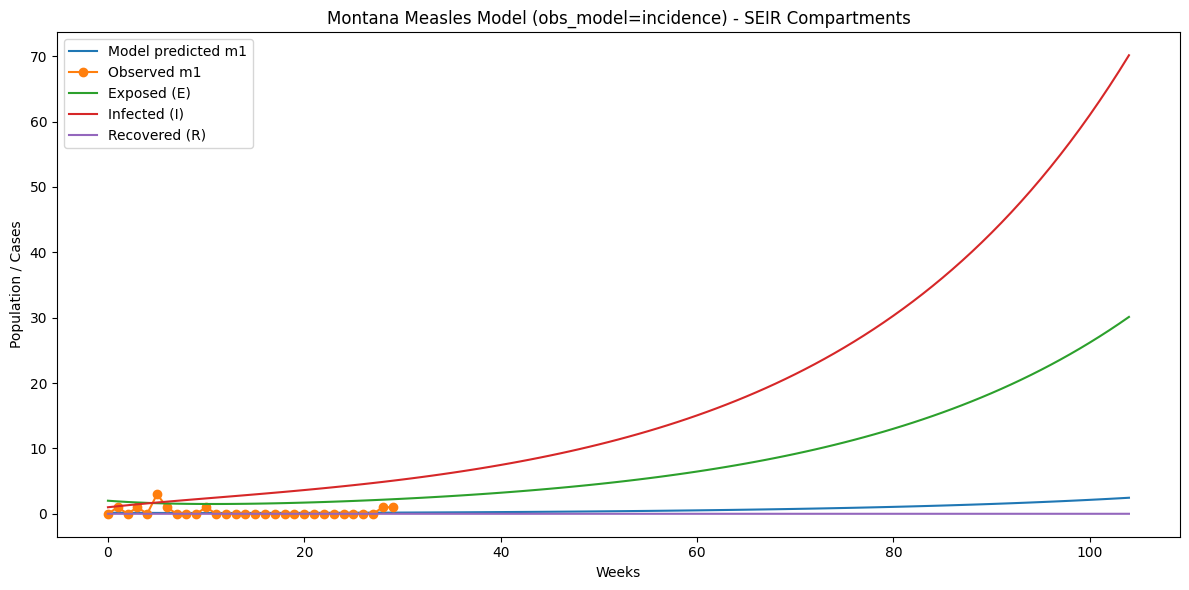

(     t_week             S          E          I             R          N  \
 0         0  1.137230e+06   2.000000   1.000000  0.000000e+00  1137233.0   
 1         1  1.137230e+06   1.895425   1.158573  8.392814e-07  1137233.0   
 2         2  1.137230e+06   1.806451   1.309273  1.798654e-06  1137233.0   
 3         3  1.137230e+06   1.731508   1.453305  2.872474e-06  1137233.0   
 4         4  1.137230e+06   1.669204   1.591755  4.055984e-06  1137233.0   
 ..      ...           ...        ...        ...           ...        ...   
 100     100  1.137146e+06  26.178851  60.974948  1.308019e-03  1137233.0   
 101     101  1.137143e+06  27.110703  63.145500  1.356242e-03  1137233.0   
 102     102  1.137140e+06  28.075722  65.393316  1.406182e-03  1137233.0   
 103     103  1.137136e+06  29.075088  67.721142  1.457900e-03  1137233.0   
 104     104  1.137133e+06  30.110023  70.131828  1.511458e-03  1137233.0   
 
      obs_pred_prevalence  obs_pred_incidence   pred_m1  
 0              

In [100]:
# yr_season, coverage_est =get_measles_vaccination_rates("Texas")
# print(f"year season: {yr_season}")
# print(f"Coverage estimate: {coverage_est}")
# dict = fit_measles_parameters("Texas", weeks_back=80, obs_model="prevalence")
# print(dict)
#Vaccination class is way too high?
run_measles_pipeline(
    "Montana",
    weeks_back=80,
    forecast_weeks=104,
    obs_model="incidence",
    reporting_rate=0.8
)

# Hepatitis B

https://www.nature.com/articles/s41598-023-39582-9#citeas  
https://worldpopulationreview.com/state-rankings/death-rate-by-state

In [101]:
def set_parameters(state, weeks_back):
  #acute confirmed cases
  df_acute_confirmed, state_pop, _, cc_AC = prep_model(state, weeks_back, "Hepatitis B, acute, Confirmed")
  df_acute_probable, _, _, cc_AP = prep_model(state, weeks_back, "Hepatitis B, acute, Probable")
  #chronic cases
  df_chronic_confirmed, _, _, cc_CC = prep_model(state, weeks_back, "Hepatitis B, chronic, Confirmed")
  df_chronic_probable, _, _, cc_CP = prep_model(state, weeks_back, "Hepatitis B, chronic, Probable")
  #perinatal cases (mother to child)
  df_perinatal_confirmed, _, _, cc_PC = prep_model(state, weeks_back, "Hepatitis B, perinatal, Confirmed")
  df_perinatal_probable, _, _, cc_PP = prep_model(state, weeks_back, "Hepatitis B, perinatal, Probable")
  del _

  if (df_acute_confirmed is None and df_acute_probable is None and
      df_chronic_confirmed is None and df_chronic_probable is None
      and df_perinatal_confirmed is None and df_perinatal_probable is None):
    print(f"[WARN] No Socrata data found for Hepatitis B in {state} for the "+
          "specified period. Cannot fit model.")
    return None

  # Handle cases where prep_model returns None
  cc_AC = 0 if cc_AC is None else cc_AC
  cc_AP = 0 if cc_AP is None else cc_AP
  cc_CC = 0 if cc_CC is None else cc_CC
  cc_CP = 0 if cc_CP is None else cc_CP
  cc_PC = 0 if cc_PC is None else cc_PC
  cc_PP = 0 if cc_PP is None else cc_PP
  #set acc case vals
  acute_cases = cc_AC + cc_AP
  chronic_cases = cc_CC + cc_CP
  perinatal_cases = cc_PC + cc_PP

  #get vaccination data
  vacc_year, vacc_rate = get_vaccination_rates("Hepatitis B",state)
  # Handle cases where vaccination data is None
  if vacc_rate is None:
      print(f"[WARN] No valid Hep B vaccination data found for {state}. Cannot fit Hepatitis B model.")
      return None

  #set params from paper I found:
  """ Khan, T., Rihan, F.A. & Ahmad, H. Modelling the dynamics of
  acute and chronic hepatitis B with optimal control. Sci Rep 13, 14980 (2023).
   https://doi.org/10.1038/s41598-023-39582-9"""
  mu_1 = 0.8 #disease death
  eta = 0.8 #maternally infected rate
  alpha = 0.95 #contact parameter
  gamma_1 = 0.004 #acute recovery rate
  gamma_2 = 0.002 #chronic recovery rate
  gamma = 0.16 #reduced transmission rate
  beta = 0.33 #acute to chronic transition rate

  ##calculated parameters
  v = vacc_rate #vaccination rate

  #natural death rate
  mu_0_df = pd.read_csv("death-rate-by-state-2025.csv")
  mu_0_row = mu_0_df[mu_0_df["state"] == state] # Fix: Use actual state
  if mu_0_row.empty:
      print(f"[WARN] No death rate found for {state}. Using average default.")
      mu_0_per_100k_per_year = 700.0 # Example average
  else:
      mu_0_per_100k_per_year = mu_0_row["DeathRateByState_2023"].values[0]
  mu_0 = (mu_0_per_100k_per_year / 100000.0) / 52.0 # Convert to per-capita weekly rate
  del mu_0_row, mu_0_df

  #birth rate
  Lambda_df = pd.read_csv("Provisional Natality, 2023 through Last Month.csv")
  Lambda_row = Lambda_df[Lambda_df["State of Residence"] == state]
  if Lambda_row.empty:
      print(f"[WARN] No birth data found for {state}. Estimating from population.")
      # Estimate total annual births based on average birth rate (e.g., 10 per 1000 population per year)
      total_annual_births = (10 / 1000) * state_pop.item()
      Lambda = total_annual_births / 52.0 # Convert to weekly births
  else:
      Lambda = Lambda_row["Births"].values[0] / 52.0 # Convert annual births to weekly births
  del Lambda_row, Lambda_df

  return {
      "mu_1": mu_1,
      "eta": eta,
      "alpha": alpha,
      "gamma_1": gamma_1,
      "gamma_2": gamma_2,
      "gamma": gamma,
      "beta": beta,
      "v": v/100,
      "mu_0": mu_0,
      "lambda": Lambda,
      "acute_cases": acute_cases,
      "chronic_cases": chronic_cases,
      "perinatal_cases": perinatal_cases,
      "state_pop": state_pop.item()
  }

In [102]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

def model_hepB(state, weeks_back, weeks_forward, params, verbose = False, y_log = False, plot = False):

  #initial conditions
  # R0 is initialized based on vaccination coverage, so 'v' is likely an initial proportion, not a continuous rate
  R0 = params["v"] * params["state_pop"]
  B0 = params["chronic_cases"] + 0.9*params["perinatal_cases"]
  A0 = params["acute_cases"] + 0.1*params["perinatal_cases"]
  S0 = max(0, params["state_pop"] - A0 - B0 - R0)

  if verbose:
    print(f"S0: {S0}, A0: {A0}, B0: {B0}, R0: {R0}")
    print(f"parameters: {params}")

  # ODE
  def deriv(t, y):
    S, A, B, R = y

    # Safeguards: Ensure compartments don't go negative during integration, and N is positive for division
    S_eff = max(0, S)
    A_eff = max(0, A)
    B_eff = max(0, B)
    R_eff = max(0, R)
    N_eff = max(1e-9, S_eff + A_eff + B_eff + R_eff) # Prevent division by zero

    # Corrected: Scale by 1/N for per-capita rates, as per typical compartmental models
    maternal_transmission_val = params["lambda"] * params["eta"] * (B_eff/N_eff)
    transmission_val = params["alpha"] * (A_eff + params["gamma"]*B_eff) * (S_eff/N_eff)

    # Removed continuous vaccination flow as params["v"] is a large proportion (e.g., 0.888)
    # and R0 is already initialized based on it. If continuous vaccination is desired,
    # 'v' must be a very small weekly rate.
    vaccination_flow_val = 0

    disease_progression_val = params["beta"]*A_eff
    recovery_val = params["gamma_2"]*B_eff
    disease_death_val = params["mu_1"] * B_eff

    # ODE Equations (Maintaining original structure as much as possible, with corrected terms)
    dS = params["lambda"] - maternal_transmission_val - transmission_val - vaccination_flow_val - params["mu_0"]*S_eff
    dA = transmission_val - disease_progression_val - params["mu_0"]*A_eff
    dB = maternal_transmission_val + disease_progression_val - disease_death_val - recovery_val - params["mu_0"]*B_eff
    dR = recovery_val + vaccination_flow_val - params["mu_0"]*R_eff

    return [dS,dA, dB, dR]

  t_eval = np.arange(0, weeks_forward + 1)
  y0 = [S0, A0, B0, R0]

  sol = solve_ivp(
    deriv,
    (0, weeks_forward),
    y0,
    t_eval=t_eval,
    method="BDF",       # or "LSODA"
    rtol=1e-3,          # much cheaper
    atol=1e-4
  )

  S, A, B, R = sol.y

  # Build results DataFrame
  results = pd.DataFrame({
        "t_week": t_eval,
        "S": S, "A": A, "B": B, "R": R,
        "N": S + A + B + R
  })

  if plot:
      try:
          # The original code attempts to plot 'pred_m1' which is not defined in this model.
          # Plotting the compartments directly for now.
          plt.figure(figsize=(12,6))
          plt.plot(results["t_week"], results["A"], label="Acute (A)")
          plt.plot(results["t_week"], results["B"], label="Chronic (B)")
          plt.xlabel("Weeks")
          plt.ylabel("Population / Cases")
          if y_log:
            plt.plot(results["t_week"], results["S"], label="Susceptible (S)")
            plt.plot(results["t_week"], results["R"], label="Recovered (R)")
            plt.yscale("log")
          plt.title(f"{state} Hepatitis B")
          plt.legend()
          plt.tight_layout()
          plt.show()
      except Exception as e:
          if verbose:
              print("Plot overlay failed:", e)

  return results


In [103]:
#hep b pipeline
def run_hepB_pipeline(state, weeks_back, weeks_forward, verbose=False):
  if verbose:
    print(f"\n=== Fitting hepatitis B parameters for {state} ===")
  params = set_parameters(state, weeks_back)
  if params is None:
    print(f"No recent data found for: {state} within the last {weeks_back} weeks")
    return None, None
  if verbose:
    print("Fitted parameters:", params)

  results = model_hepB(
      state,
      weeks_back,
      weeks_forward,
      params,
      plot = True,
      verbose=verbose
  )
  return results, params

In [ ]:
results, params = run_hepB_pipeline("Alabama", weeks_back=10, weeks_forward=10, verbose=True)


=== Fitting hepatitis B parameters for Alaska ===
[WARN] No Socrata data found for Hepatitis B, acute, Confirmed in Alaska for the specified period. Returning None for all.
[WARN] No Socrata data found for Hepatitis B, acute, Probable in Alaska for the specified period. Returning None for all.


[WARN] No Socrata data found for Hepatitis B, perinatal, Confirmed in Alaska for the specified period. Returning None for all.
[WARN] No Socrata data found for Hepatitis B, perinatal, Probable in Alaska for the specified period. Returning None for all.


AttributeError: 'NoneType' object has no attribute 'item'